# Discover sentiment in Airbnb reviews

Sentiment analysis is commonly used in marketing and customer service to answer questions such as "Is a customer review positive or negative?" and "How are customers responding to the service?"

*Topic modeling* discovers the abstract topics in a corpus of texts. The results from topic modeling analysis can then be used in sentiment analysis. For example, they can be used to split texts into different subsets and allow us to train a separate sentiment model for each of the subsets. Training separate sentiment models for different subsets can lead to more accurate predictions than using a single model for all the texts. 

This notebook discovers and visualizes topics from Airbnb reviews.

In [1]:
import pandas as pd
reviews = pd.read_csv("raw/Apr19/reviews.csv", header = 0)
print(reviews.shape)

(542511, 6)


Remove non-letters and change to lower case:

In [2]:
import re

def clean_text(string_in):
    string_in = re.sub("[^a-zA-Z]", " ", str(string_in))  # Replace all non-letters with spaces
    string_in = string_in.lower()                         # Tranform to lower case    
    
    return string_in.strip()

reviews["comments_cleaned"] = reviews.comments.apply(clean_text)

Tokenize the text data

In [3]:
from nltk.tokenize import RegexpTokenizer
preprocessed = [" ".join(RegexpTokenizer(r'\w+').tokenize(reviews.comments_cleaned[idx])) for idx in reviews.index]

## Identify topics

### Calculate tf-idf matrix

In order to use non-negative matrix factorization, I first calculated the *tf-idf* (term frequency-inverse document frequency) matrix. The value of tf-idf reflects the number times a word appears in the *document* after adjusting for the frequency of the word in the *corpus*. 

When calculating the tf-idf matrix, I filtered out words like "being" and "for" which are called *stop words*. I used the stop words as defined by the [scikit-learn](http://scikit-learn.org/stable/) package. I can expand the list of stop words by adding to the `custom_stop_words` variable.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

custom_stop_words = []
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))

Created document-term matrix of size 542511 x 73517


# NMF analysis


If we use **V<span>** to represent a **document-word** matrix with tf-idf values, non-negative matrix factorization factorizes the matrix into two matrices **W<span>** and **H<span>**, representing **document-topic** and **topic-word** matrices, respectively, as shown in the following figure:

![Figure 1](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)

The **document-topic** matrix or **W<span>** matrix allows us to compare texts and determine which ones are similar. The **topic-word** matrix, or **H<span>** matrix tells us the top words in any given topic and we can use visualization to better undertand the topics.


Now I can use NMF on the derived tf-idf matrix. We specify the number of topics to be 5.

In [5]:
from sklearn import decomposition
import numpy as np
nmf = decomposition.NMF(init = 'nndsvd', n_components = 5, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated W(document-topic)) matrix of size %s and H (topic-word) matrix of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()
n_top_words = 10

# Print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated W(document-topic)) matrix of size (542511, 5) and H (topic-word) matrix of size (5, 73517)
Topic #0:
apartment clean stay recommend melbourne comfortable close perfect lovely easy

Topic #1:
great location host apartment communication place value stay view views

Topic #2:
good location value clean communication money host room house really

Topic #3:
place nice stay really clean recommend great amazing lovely awesome

Topic #4:
canceled automated posting reservation arrival days host friendly day helpful



## Visualize topics with a word cloud

To better communicate the topics found, I used the [wordcloud](https://github.com/amueller/word_cloud) package.

In [7]:
!pip install wordcloud

Separate the topics into separate sorted lists:

In [8]:
# Create pandas dataframe for the topics
mydf = pd.DataFrame({"feature_name": feature_names})

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

reviews_topic1 = []
reviews_topic2 = []
reviews_topic3 = []
reviews_topic4 = []
reviews_topic5 = []

for order_id, key, num1, num2, num3, num4, num5 in mylist:
    reviews_topic1.append((key, num1))
    reviews_topic2.append((key, num2))
    reviews_topic3.append((key, num3))
    reviews_topic4.append((key, num4))
    reviews_topic5.append((key, num5))

reviews_topic1 = sorted(reviews_topic1, key=lambda myword: myword[1], reverse=True)
reviews_topic2 = sorted(reviews_topic2, key=lambda myword: myword[1], reverse=True)
reviews_topic3 = sorted(reviews_topic3, key=lambda myword: myword[1], reverse=True)
reviews_topic4 = sorted(reviews_topic4, key=lambda myword: myword[1], reverse=True)
reviews_topic5 = sorted(reviews_topic5, key=lambda myword: myword[1], reverse=True)

Generate the word cloud for the 5 topics identified from NMF. Larger fonts indicate higher weights of the words in a topic and the colors are randomly assigned. Compared with a simple list, from a word cloud we can better understand the relative frequency of all the words:

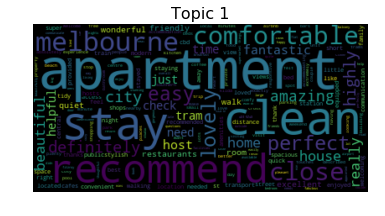

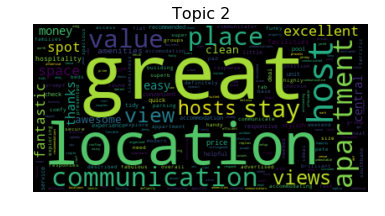

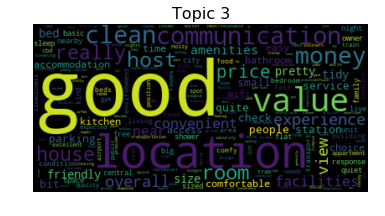

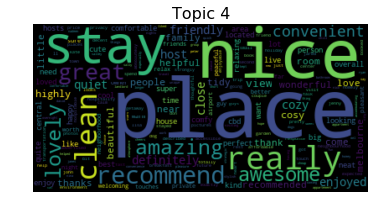

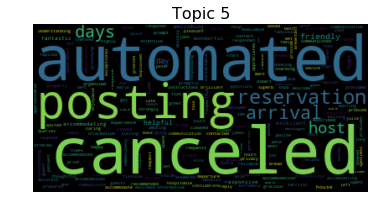

In [9]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline

def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    
    plt.title('Topic %s' %str(topic_number), size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

draw_wordcloud(dict(reviews_topic1), topic_number=1)
draw_wordcloud(dict(reviews_topic2), topic_number=2)
draw_wordcloud(dict(reviews_topic3), topic_number=3)
draw_wordcloud(dict(reviews_topic4), topic_number=4)
draw_wordcloud(dict(reviews_topic5), topic_number=5)

## Making predictions

For any new reviews, I can calculate its tf-idf matrix and then calculate its **Document-Topic** matrix. This will then allow us to assign the new reviews to a segment and predict its sentiment (for example, positive sentiment vs. negative sentiment on a product).

For example: 

In [10]:
# Prediction example
text_new = preprocessed[0:5]
tfidf_new = vectorizer.transform(text_new)
DT_new = nmf.transform(tfidf_new)